In [13]:
import os

from tqdm import tqdm
import time

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [14]:
data = pd.read_csv("../data/AAPL_dataset_copied.csv")
data.head()

,i,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [15]:
target = 'target'
prediction_length = 128
id_column = 'item_id'
timestamp_column = 'timestamp'
timeseries_id = 'AAPL'

data = pd.read_csv("../data/AAPL_dataset_copied.csv").drop(['i'], axis=1)
data = data.rename(columns={'close': target, 'symbol': id_column, 'date': timestamp_column})

data[timestamp_column] = pd.to_datetime(data[timestamp_column].str.slice(0, 19))
data = data.sort_values(by=[timestamp_column])

# reindex into business days
date_index = pd.date_range(
    start=data[timestamp_column].min(),
    end=data[timestamp_column].max(),
    freq="B"
)

# reindex and restore timestamp
data = data.set_index(timestamp_column).reindex(date_index)
data.index.name = timestamp_column
data = data.reset_index()


data[id_column] = timeseries_id



# Rebuild context and future parts
context_df = data.iloc[: -prediction_length]
test_df = data.iloc[-prediction_length:]
future_df = test_df.drop(columns=[target])


print("Full dataframe shape: ", data.shape)

print("Input dataframe shape: ", context_df.shape)
display(context_df.head())

print("Test dataframe shape: ", test_df.shape)
display(test_df.head())

print("Future dataframe shape: ", future_df.shape)
display(future_df.head())

print(data.columns)


Full dataframe shape:  (1303, 14)
Input dataframe shape:  (1175, 14)


,timestamp,item_id,target,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2015-05-27,AAPL,132.045,132.260,130.05,130.34,45833246.0,121.682558,121.880685,119.844118,120.111360,45833246.0,0.0,1.0
1,2015-05-28,AAPL,131.780,131.950,131.10,131.86,30733309.0,121.438354,121.595013,120.811718,121.512076,30733309.0,0.0,1.0
2,2015-05-29,AAPL,130.280,131.450,129.90,131.23,50884452.0,120.056069,121.134251,119.705890,120.931516,50884452.0,0.0,1.0
3,2015-06-01,AAPL,130.535,131.390,130.05,131.20,32112797.0,120.291057,121.078960,119.844118,120.903870,32112797.0,0.0,1.0
4,2015-06-02,AAPL,129.960,130.655,129.32,129.86,33667627.0,119.761181,120.401640,119.171406,119.669029,33667627.0,0.0,1.0


Test dataframe shape:  (128, 14)


,timestamp,item_id,target,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1175,2019-11-27,AAPL,267.84,267.98,265.31,265.58,16386122.0,266.492497,266.631793,263.975225,264.243867,16386122.0,0.0,1.0
1176,2019-11-28,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1177,2019-11-29,AAPL,267.25,268.00,265.90,266.60,11654363.0,265.905465,266.651692,264.562257,265.258735,11654363.0,0.0,1.0
1178,2019-12-02,AAPL,264.16,268.25,263.45,267.27,23693550.0,262.831011,266.900434,262.124583,265.925365,23693550.0,0.0,1.0
1179,2019-12-03,AAPL,259.45,259.53,256.29,258.31,29377268.0,258.144707,258.224305,255.000605,257.010442,29377268.0,0.0,1.0


Future dataframe shape:  (128, 13)


,timestamp,item_id,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1175,2019-11-27,AAPL,267.98,265.31,265.58,16386122.0,266.492497,266.631793,263.975225,264.243867,16386122.0,0.0,1.0
1176,2019-11-28,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1177,2019-11-29,AAPL,268.00,265.90,266.60,11654363.0,265.905465,266.651692,264.562257,265.258735,11654363.0,0.0,1.0
1178,2019-12-02,AAPL,268.25,263.45,267.27,23693550.0,262.831011,266.900434,262.124583,265.925365,23693550.0,0.0,1.0
1179,2019-12-03,AAPL,259.53,256.29,258.31,29377268.0,258.144707,258.224305,255.000605,257.010442,29377268.0,0.0,1.0


Index(['timestamp', 'item_id', 'target', 'high', 'low', 'open', 'volume',
       'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash',
       'splitFactor'],
      dtype='object')


In [16]:
pred_df = pipeline.predict_df(
    context_df,
    future_df = future_df,
    prediction_length = prediction_length,
    quantile_levels = [0.1, 0.5, 0.9],
    id_column = id_column,
    timestamp_column = timestamp_column,
    target = target,
    #batch_size = 256,
    #inputs = { "past_time_features": True, "future_time_features": True },
)

pred_df.head(10)

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,AAPL,2019-11-27,target,267.874939,261.803711,267.874939,273.059143
1,AAPL,2019-11-28,target,229.136047,221.644196,229.136047,236.363678
2,AAPL,2019-11-29,target,264.238556,257.773651,264.238556,269.291321
3,AAPL,2019-12-02,target,265.446045,260.213867,265.446045,271.137787
4,AAPL,2019-12-03,target,261.433136,256.901794,261.433136,265.349304
5,AAPL,2019-12-04,target,263.039490,257.748230,263.039490,267.952606
6,AAPL,2019-12-05,target,264.641541,260.150452,264.641541,269.219299
7,AAPL,2019-12-06,target,266.754883,261.743958,266.754883,271.595764
8,AAPL,2019-12-09,target,267.601501,262.526489,267.601501,272.270782
9,AAPL,2019-12-10,target,267.496216,263.150085,267.496216,272.390167


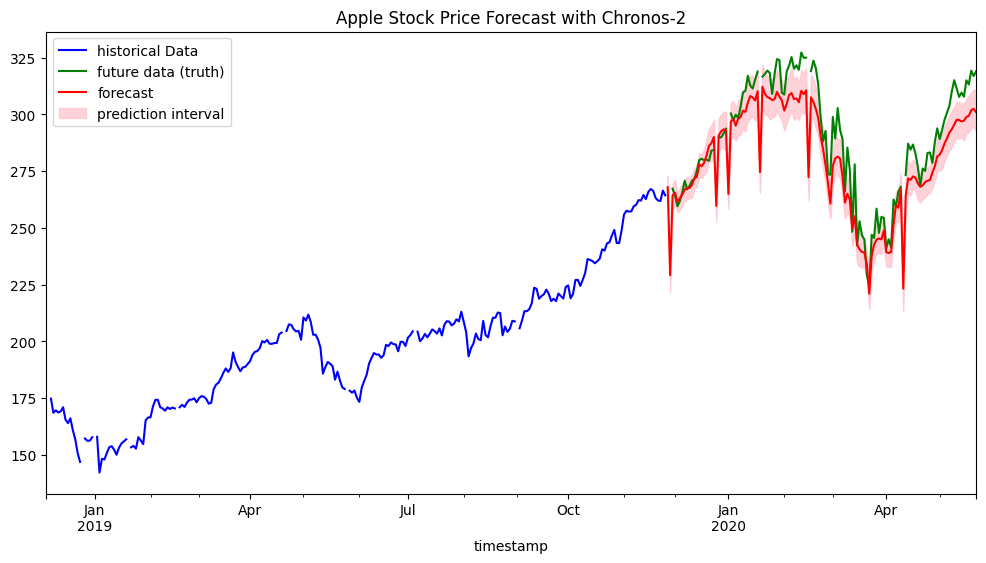

In [18]:
import matplotlib.pyplot as plt

ts_context = context_df.set_index("timestamp")["target"].tail(256)
ts_pred = pred_df.set_index("timestamp")
ts_gound_truth = test_df.set_index("timestamp")["target"]

ts_context.plot(label="historical Data", color="blue", figsize=(12, 6))
ts_gound_truth.plot(label="future data (truth)", color="green")
ts_pred["predictions"].plot(label="forecast", color ="red")

plt.fill_between(
    ts_pred.index,
    ts_pred["0.1"],
    ts_pred["0.9"],
    color="pink",
    alpha=0.7,
    label="prediction interval",
)
plt.legend()
plt.title("Apple Stock Price Forecast with Chronos-2")
plt.show()